In [1]:
import torch
from torch.utils.data import DataLoader
from datasets.cfg import num_classes, max_size
from models.models import build_model
from datasets.loader import DataModule, DataConfig
from datasets.base import collate_bb
from train.eval import Evaluator
from train.unsupervised_metrics import UnlabeledSanity

device = torch.device("cuda")

model_B = build_model("maskrcnn_r50_fpn", num_classes).to(device)
model_B.load_state_dict(torch.load("./weights/maskrcnn_B_ep40.pth", map_location="cuda"))

model_AB = build_model("maskrcnn_r50_fpn", num_classes).to(device)
model_AB.load_state_dict(torch.load("./weights/maskrcnn_AB_ep40.pth", map_location="cuda"))

data = DataModule(DataConfig())
loader_B_test = data.make_loader_b_test()
loader_A_val  = data.make_loader_a_val()
loader_C_test  = data.make_loader_c_test()

/home/neoph/dev/Train/.tenv312/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/neoph/dev/Train/.tenv312/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/tmp/ipykernel_3168692/3733450509.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value 

In [2]:
e = Evaluator(device)
mb_B  = e.metrics_masks(model_B,  loader_B_test, num_classes=num_classes - 1)
mb_AB = e.metrics_masks(model_AB, loader_B_test, num_classes=num_classes - 1)

rows = [
    ["setup", "mAP50", "PQ_all", "mPQ", "AJI"],
    ["Model B", f"{mb_B['mAP50']:.3f}",  f"{mb_B['PQ_all']:.3f}",  f"{mb_B['mPQ']:.3f}",  f"{mb_B['AJI']:.3f}"],
    ["Model A+B",   f"{mb_AB['mAP50']:.3f}", f"{mb_AB['PQ_all']:.3f}", f"{mb_AB['mPQ']:.3f}", f"{mb_AB['AJI']:.3f}"],
]
print("\n=== B-test metrics ===")
e.print_table(rows)

map50_A_val = e.map50(model_AB, loader_A_val)
print(f"\nA-val mAP50 (boxes, A+B model): {map50_A_val:.3f}")

map50_C = e.map50(model_AB, loader_C_test)
print(f"\nChromo-CRCN test mAP50 (boxes, A+B model): {map50_C:.3f}")


=== B-test metrics ===
setup      mAP50  PQ_all  mPQ    AJI  
Model B    0.885  0.582   0.581  0.504
Model A+B  0.905  0.652   0.651  0.599

A-val mAP50 (boxes, A+B model): 0.964

Chromo-CRCN test mAP50 (boxes, A+B model): -1.000


In [4]:
loader_D_test  = data.make_loader_d_test()

In [ ]:
sanity = UnlabeledSanity(num_classes=24)
san_scores_ab_b = e.sanity(model_AB, loader_B_test, sanity)
san_scores_b_b = e.sanity(model_B, loader_B_test, sanity)
san_scored_ab_d = e.sanity(model_AB, loader_D_test, sanity)

In [6]:
ds = san_scores_b_b["dataset_scores"]

r0 = san_scores_b_b["per_image"][0] #sanity for one image
print("B model: image 0 -> n:", r0.n_instances, "sex:", r0.sex_pattern)

r0 = san_scores_ab_b["per_image"][0] #sanity for one image
print("AB model: image 0 -> n:", r0.n_instances, "sex:", r0.sex_pattern)

print("\n=== Unlabeled B-test sanity (B model) ===")
print("total:", f"{ds['total']:.3f}",
      "count:", f"{ds['count']:.3f}",
      "balance:", f"{ds['class_balance']:.3f}",
      "sex:", f"{ds['sex']:.3f}",
      "size:", f"{ds['size']:.3f}")

ds = san_scores_ab_b["dataset_scores"]
print("\n=== Unlabeled B-test sanity (A+B model) ===")
print("total:", f"{ds['total']:.3f}",
      "count:", f"{ds['count']:.3f}",
      "balance:", f"{ds['class_balance']:.3f}",
      "sex:", f"{ds['sex']:.3f}",
      "size:", f"{ds['size']:.3f}")

ds = san_scored_ab_d["dataset_scores"]
print("\n=== Unlabeled D-test sanity (A+B model) ===")
print("total:", f"{ds['total']:.3f}",
      "count:", f"{ds['count']:.3f}",
      "balance:", f"{ds['class_balance']:.3f}",
      "sex:", f"{ds['sex']:.3f}",
      "size:", f"{ds['size']:.3f}")

B model: image 0 -> n: 100 sex: XX
AB model: image 0 -> n: 100 sex: None

=== Unlabeled B-test sanity (B model) ===
total: 0.483 count: 0.284 balance: 0.423 sex: 0.284 size: 0.940

=== Unlabeled B-test sanity (A+B model) ===
total: 0.638 count: 0.529 balance: 0.580 sex: 0.504 size: 0.939

=== Unlabeled D-test sanity (A+B model) ===
total: 0.763 count: 0.654 balance: 0.696 sex: 0.771 size: 0.932



Examples: B-test, B model


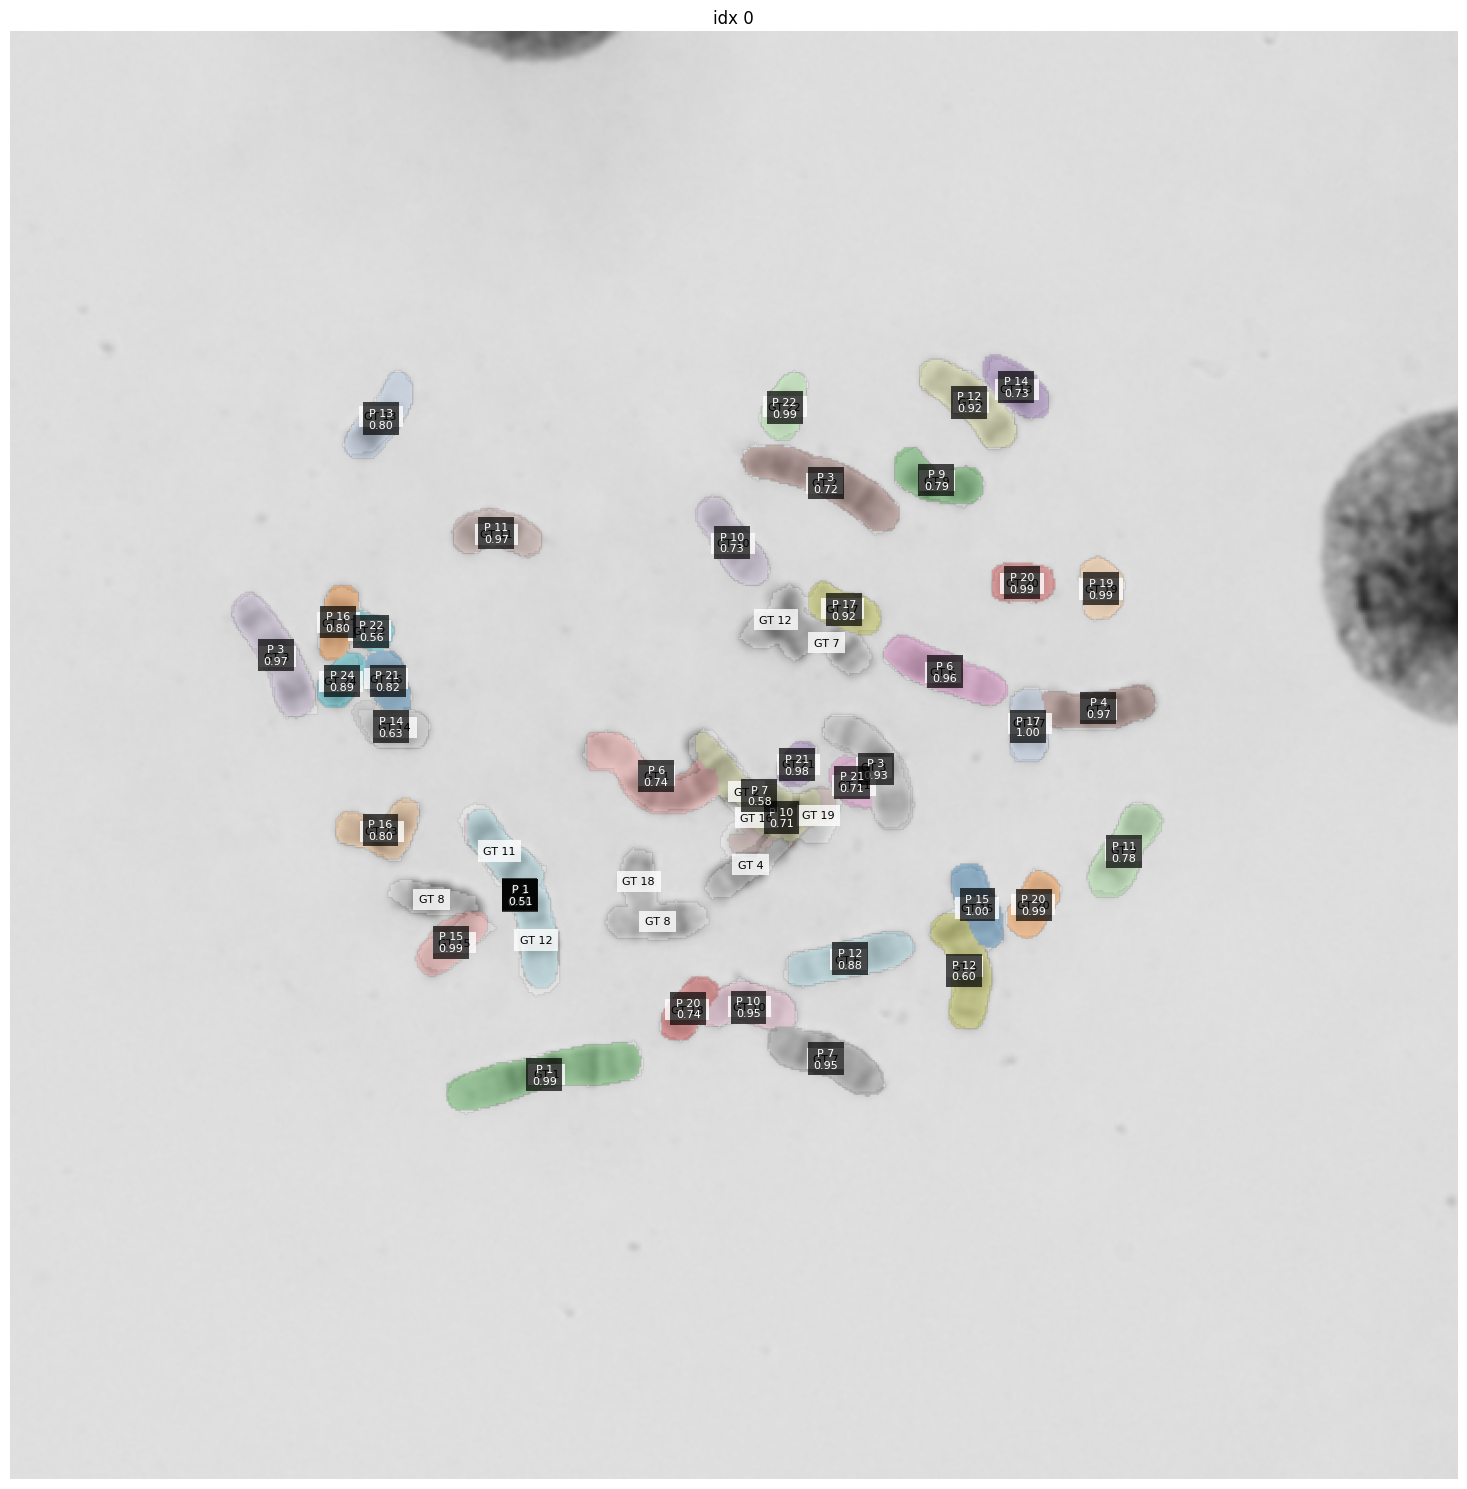


Examples: B-test, A+B model


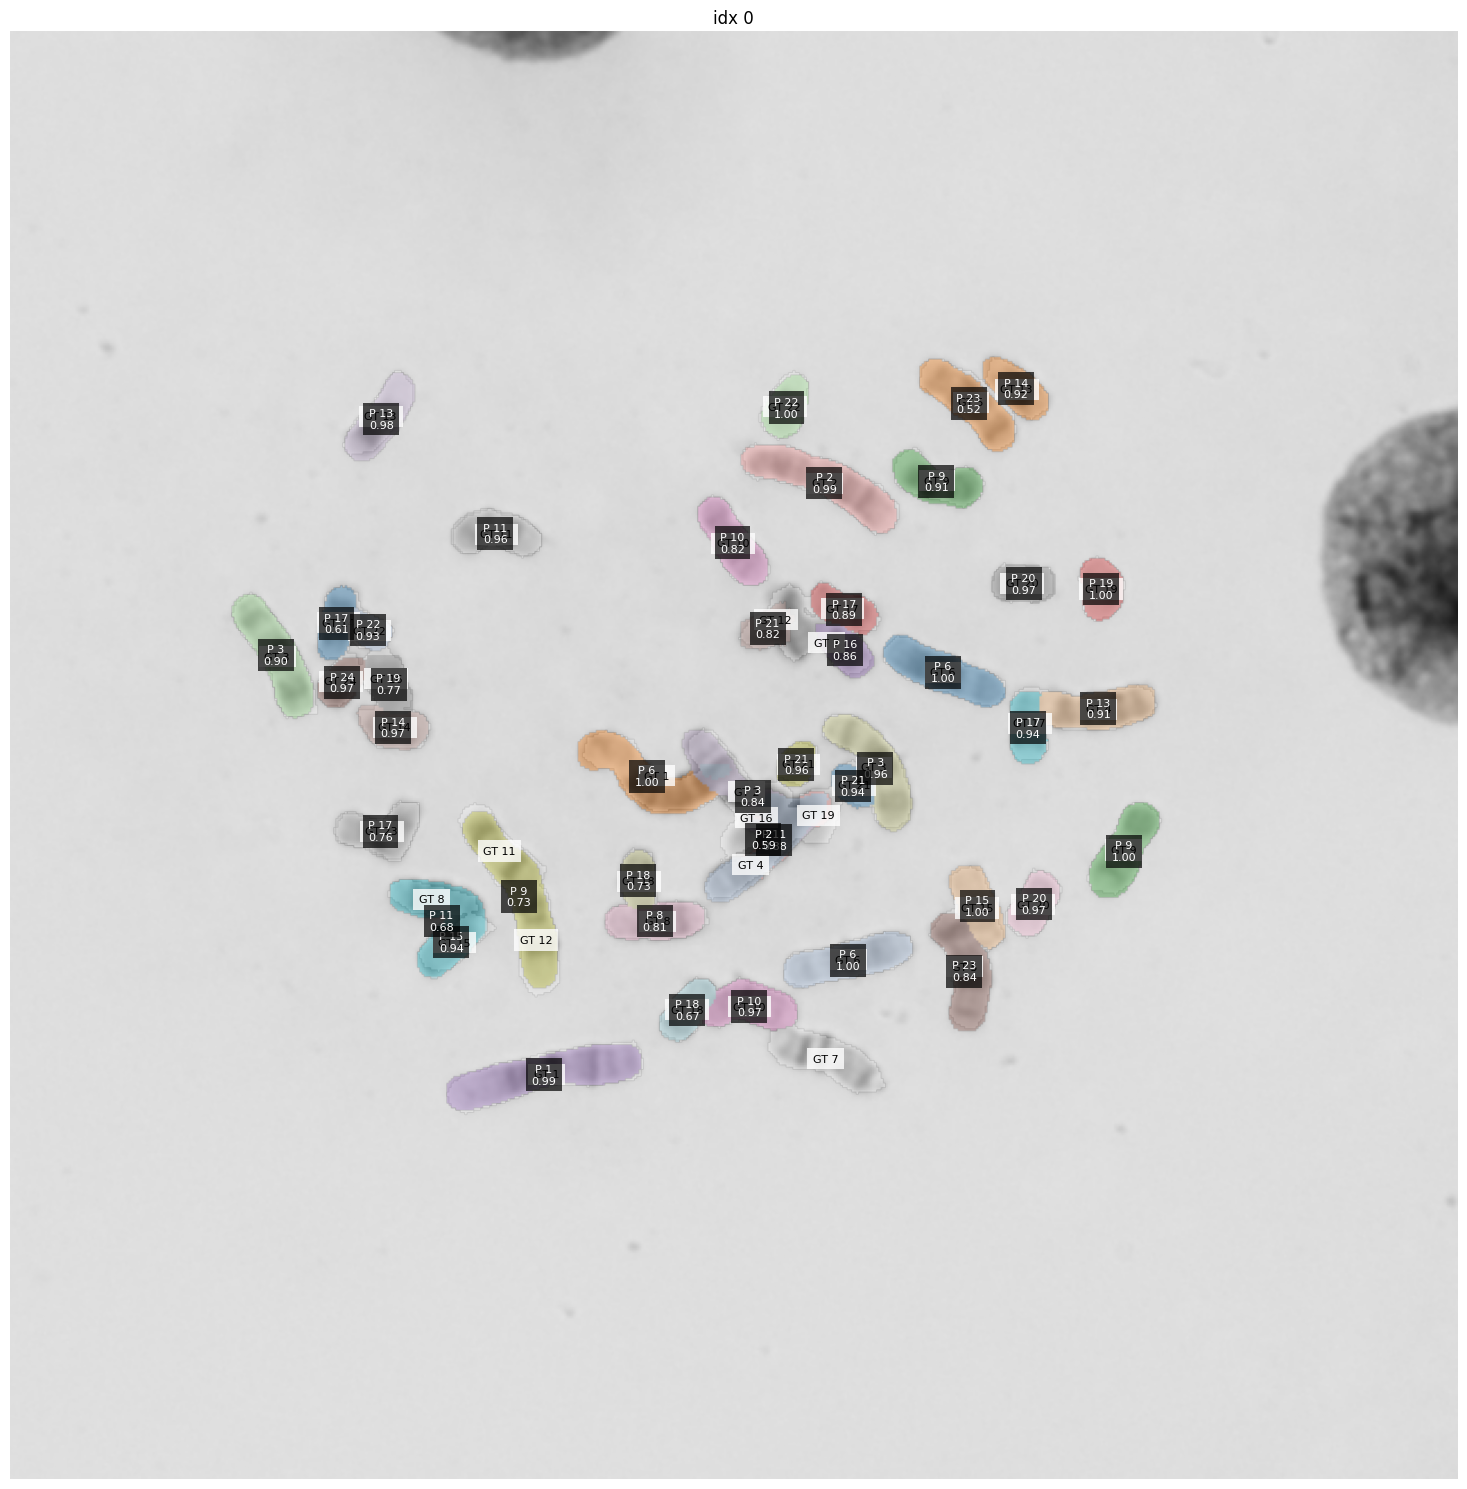

In [7]:
e.show_examples(data.ds_b_test, model_B,  n=1, score_thresh=0.5, title="B-test, B model")
e.show_examples(data.ds_b_test, model_AB, n=1, score_thresh=0.5, title="B-test, A+B model")

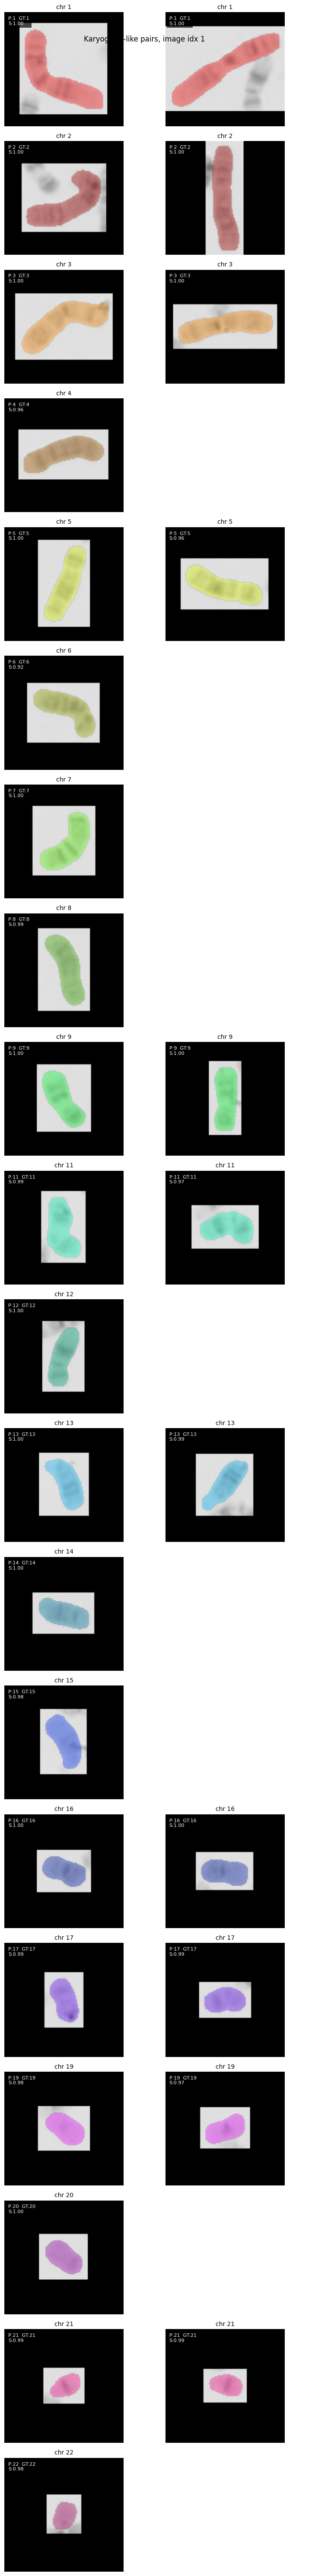

In [17]:

from train.karyo_plotting4 import plot_karyogram_from_output

def plot_karyogram_from_dataset(dataset, model, idx=0, score_thresh=0.5, pad=5):
    model.eval()
    img_t, target = dataset[idx]
    img_t = img_t.to(device)

    with torch.no_grad():
        out = model([img_t])[0]

    plot_karyogram_from_output(img_t.cpu(), out, target, idx=idx, score_thresh=score_thresh, pad=pad)

plot_karyogram_from_dataset(data.ds_b_test, model_AB, idx= 1)

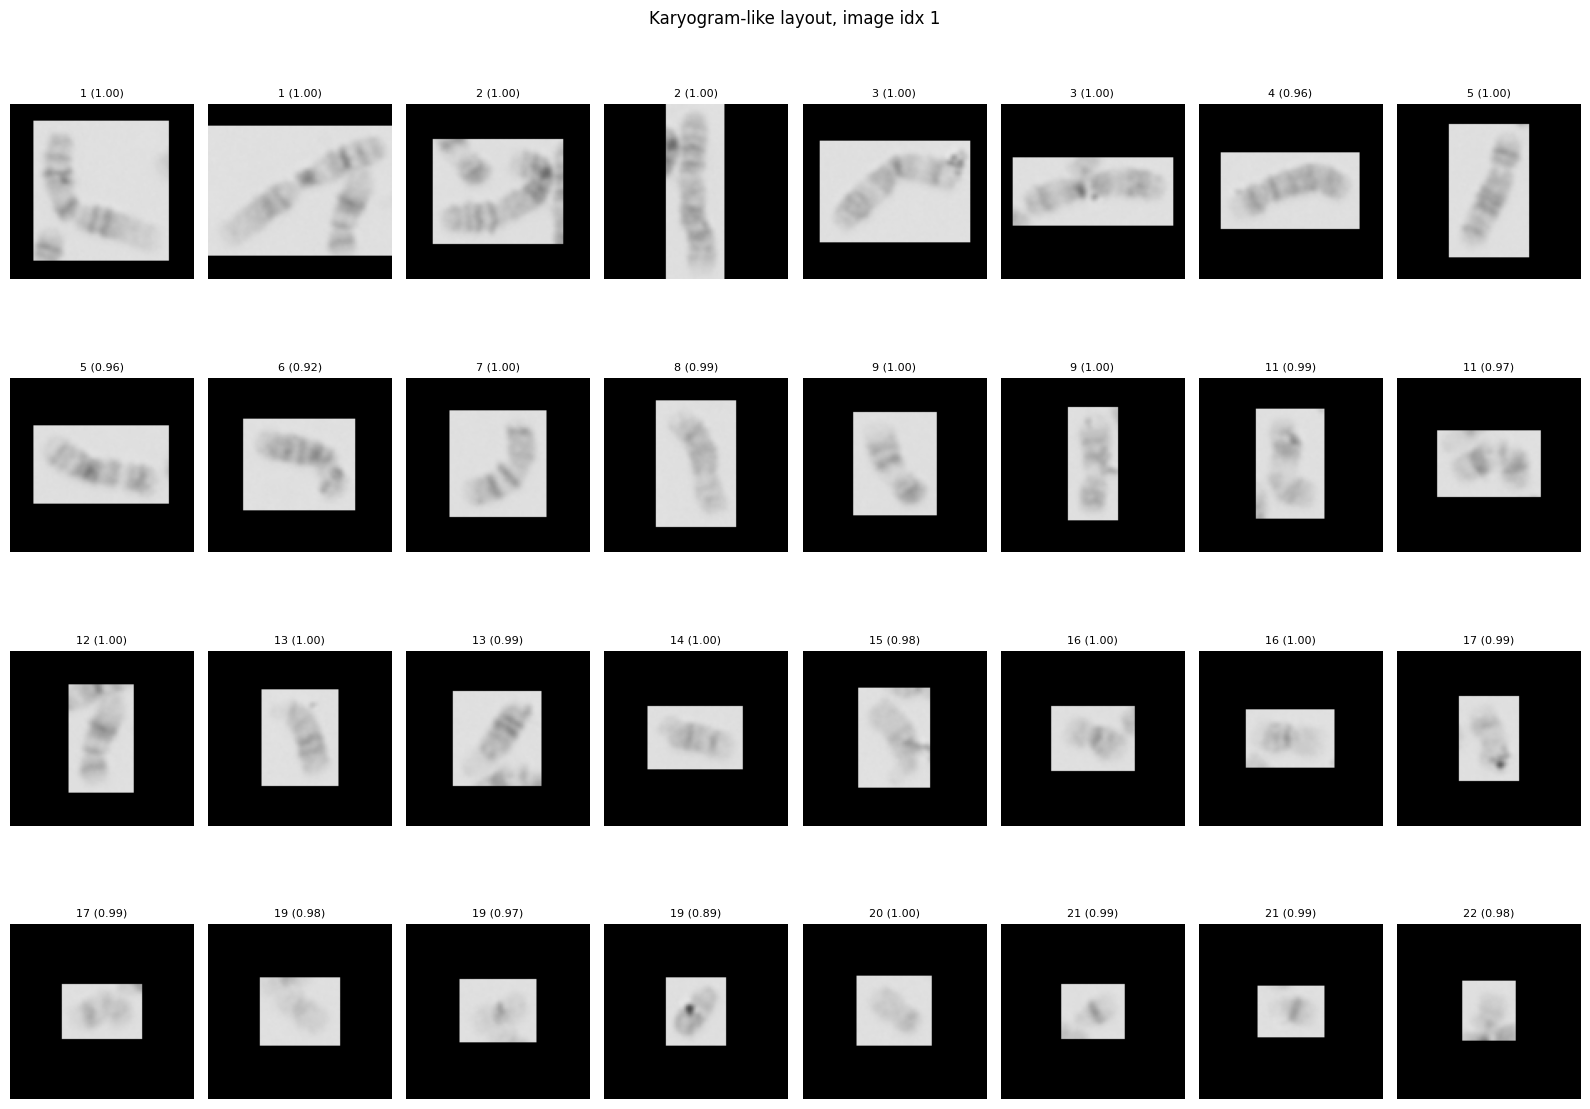

In [15]:
from train.karyo_plotting2 import plot_karyogram_from_output

def plot_karyogram_from_dataset(dataset, model, idx=0, score_thresh=0.5,pad=5,cols=8):
    model.eval()
    img_t, _ = dataset[idx]
    img_t = img_t.to(device)

    with torch.no_grad():
        out = model([img_t])[0]

    plot_karyogram_from_output(img_t.cpu(), out, idx, score_thresh, pad, cols)

plot_karyogram_from_dataset(data.ds_b_test, model_AB, idx= 1)